In [1]:
import os

modelname = 'src/model1.1.1_pan/'

os.system('mkdir -p ./'+modelname)
outputf = open(modelname+'/output.txt', 'w')

outputf.write('OMP_NUM_THREADS = '+str(os.popen('echo $OMP_NUM_THREADS').read()) +'\n\n')

21

In [2]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import keras, os, struct

Using TensorFlow backend.


In [3]:
#lsstr = "ls /home/xiaodongli/data/colas/cola_multiverse/om_As/"
lsstr = "ls /media/cosmo/Seagate/cola_multiverse/om_As/"

def cosmostr(om, As):
    return 'om%.3f' % om + '_As%.3f' % As

def snpfiles(cosmology, snpstr='c'):  #
    return os.popen(lsstr + cosmology + "*snap*" + snpstr + ".*").read().split()

def gridfiles(cosmology, snpstr='c'):
    return os.popen(lsstr + cosmology + "*grid*" + snpstr + ".*").read().split()

def mocklist():
    files = os.popen(lsstr + "om*.lua").read().split('\n')
    # *代替多个字母,即列出所有符合条件的.lua文件:om...
    cosmologies = []  # 宇宙学参数
    mocks = {}  # 模拟测试
    ifile = 0  # 有效文件
    for nowfile in files:
        # str[a:b]不存在时,返回'',不存在则忽略
        nowstr = nowfile[-39:-10]
        if nowstr == '':
            continue
        cosmologies.append(nowstr[0:15])
        ifile += 1
        try:
            mocks[nowstr[0:15]] = {'om': float(nowstr[2:7]), 'As': float(nowstr[10:15]),
                                   'sigma8': float(nowstr[23:29])}
            # 添加随机数种子
            ranseed = float(open(nowfile, 'r').readline().split()[2])  # 默认以所有空字符为分隔符,包括空格,\n,\t
            mocks[nowstr[0:15]]['ranseed'] = int(ranseed)
            # print(ranseed)
        except:
            pass
    return cosmologies, files, mocks

gridfile_dict = {}

cosmologies, filenames, infos = mocklist()
print('In total ', len(cosmologies), 'cosmologies')
outputf.write('In total '+str(len(cosmologies))+'cosmologies\n')

print('Build up gridfile_dict... (for speed-up of load_grid()) ')
outputf.write('Build up gridfile_dict... (for speed-up of load_grid()) \n')
for cosmology in cosmologies:
    rlt = gridfiles(cosmology)
    if rlt == []:
        print ('\tmissing cosmology!', cosmology)
        outputf.write('\tmissing cosmology!' +str(cosmology)+ '\n')
    else:
        gridfile_dict[cosmology] = rlt[0]
np.random.shuffle(cosmologies)

In total  465 cosmologies
Build up gridfile_dict... (for speed-up of load_grid()) 
	missing cosmology! om0.180_As2.040
	missing cosmology! om0.180_As2.100
	missing cosmology! om0.180_As2.120
	missing cosmology! om0.180_As2.140
	missing cosmology! om0.180_As2.200
	missing cosmology! om0.180_As2.220
	missing cosmology! om0.180_As2.260


In [4]:
def load_grid(gridfile, snpstr='c', printinfo=False):  # 网格加载
    #gridfile = os.popen(lsstr + cosmology+"_sigma8_*grid*" + snpstr + ".*").read().split()[0]
    #print('load in gridfile : ', gridfile, '...')
    nowf = open(gridfile, 'rb')  # 以二进制形式读取文件
    # struct:对python基本类型值与用python字符串格式表示的C struct类型间转化
    size = struct.unpack('f' * 1, nowf.read(4 * 1))[0]
    grid_nc = struct.unpack('i' * 1, nowf.read(4 * 1))[0]
    data = struct.unpack('f' * grid_nc ** 3, nowf.read(4 * grid_nc ** 3))
    if printinfo:
        print('read in box size     \n\t', size)
        print('read in num_grid      \n\t', grid_nc)
        print('read in coarse grid \n\tsize    : ', len(data), '\n\texpect  : ', grid_nc ** 3)

    nowf.close()
    return np.array(data).reshape((grid_nc, grid_nc, grid_nc))

def subcubes(A):
    rlt = []
    for row1 in [0, 32, 64, 96]:
        for row2 in [0, 32, 64, 96]:
            for row3 in [0, 32, 64, 96]:
                rlt.append(A[row1:row1+32,row2:row2+32,row3:row3+32])
    return rlt

def data_augument(A):
    rlt = []

In [5]:
test_size = 0.3
batch_size = 6
num_subcube = 64
num_data_augument = 48

x_train = np.zeros((batch_size-int(test_size*batch_size)-1, 2))  # 因test_size=0.3,保证初始化矩阵的形状与后面的相同
x_test = np.zeros((int(test_size*batch_size)+1,32,32,32, 1))
y_test = np.zeros((int(test_size*batch_size)+1, 2))
y_train = np.zeros((batch_size-int(test_size*batch_size)-1, 2))


###  xiaodong: 重新写了 load_grid 程序。。。之前有错误！！！！（好像只会 load 进来一个 om...)
def train_generator():  # 必须无限循环yield数据,全部数据遍历后再重新遍历数据,为下一个epoch yield 数据
    i = 0
    while 1:
        X = []
        y = []
        global x_train, x_test, y_test, y_train, test_size, batch_size
        #print(' load in ', batch_size * i, 'to', batch_size * (i + 1), '... len(cosmologies)=',
        #      len(cosmologies))
        for cosmology in cosmologies[batch_size * i: batch_size * (i + 1)]:
            try:
                gridfile = gridfile_dict[cosmology]
                gridfile_exist = True
            except:
                #print('skip cosmology ', cosmology, '!!!')
                gridfile_exist = False
            if gridfile_exist:
                griddata = load_grid(gridfile, 'c')
                for subcube in subcubes(griddata):
                    X.append(subcube)
                    y.append(np.array([infos[cosmology]['om'], infos[cosmology]['sigma8']]))
        X = np.array(X)
        y = np.array(y)
        x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size)
        x_train = x_train.reshape(-1, 32, 32, 32, 1)
        x_test = x_test.reshape(-1, 32, 32, 32, 1)
        i += 1
        yield x_train, y_train  # tuple 类型
        # 15个批次后重新遍历数据,此循环即死循环
        if i == 465//batch_size:
            i = 0


# In[46]:


from keras import Sequential, layers
from sklearn import model_selection, metrics


def create_validate_sample(nsample, use_random=True, startid=None ):
    cosmologies = list(gridfile_dict); ncosmo = len(cosmologies)
    if use_random:
        rows = [np.random.randint(0,ncosmo) for row in range(nsample)];
        rows = list(set(rows))
        while len(rows) < nsample:
            rows = rows + [np.random.randint(0,ncosmo) for row in range(nsample - len(rows))];
            rows = list(set(rows))
    else:
        rows = range(startid, startid+nsample)
    x, y =[], []
    for row in rows:
        cosmology = cosmologies[row]
        gridfile = gridfile_dict[cosmology]
        griddata = load_grid(gridfile)
        for subcube in subcubes(griddata):
            x.append(subcube)
            y.append(np.array([infos[cosmology]['om'], infos[cosmology]['sigma8']]))
    x = np.array(x); x = x.reshape(-1, 32, 32, 32, 1); y = np.array(y)
    return x, y

def plot_test(model, x, y, plot_avg_predict = True, fig=None, ax = None, plot_subpoints=False):
    y_predict = model.predict(x); 
    
    if fig == None or ax ==None:
        fig, ax = plt.subplots(figsize=(14,6))
    cs = range(len(y)); cs = cs / mean(cs)
    ax.scatter(y[:,0], y[:,1], c='b', marker='*', label='input', s=200)
    if plot_subpoints:
        ax.scatter(y_predict[:,0], y_predict[:,1], c='g',  marker='p', s=50, label='outputs')
    
        
    om_test, w_test = y[:,0], y[:,1]
    om_predict, w_predict = y_predict[:,0], y_predict[:,1]
    
    if plot_avg_predict:
        ax.scatter(mean(y_predict[:,0]), mean(y_predict[:,1]), marker='*', c='r', label='output_avg', s=200)
        ax.plot([om_test[0], mean(y_predict[:,0])], [w_test[0], mean(y_predict[:,1])], lw=2, c='k', ls='--' )

    
    #for row in range(len(om_predict)):
    #    ax.plot( [om_predict[row], om_test[row]], [w_predict[row], w_test[row]], lw=0.5, c='gray' )
    ax.set_xlabel(r'$\Omega_m$',fontsize=16); ax.set_ylabel(r'$\sigma_8$',fontsize=16)
    ax.legend()   
    return fig, ax

In [11]:
max_epochs = 300

nowmodel = keras.Sequential([
        layers.BatchNormalization( input_shape=(32, 32, 32, 1)),
        layers.Conv3D(32, (3, 3, 3), activation='relu'),
        layers.AveragePooling3D(pool_size=(2, 2, 2)),
        layers.BatchNormalization(),
        layers.Conv3D(64, (3, 3, 3), activation='relu'),
        layers.AveragePooling3D(pool_size=(2, 2, 2)),
        layers.BatchNormalization(),
        layers.Conv3D(128, (3, 3, 3), activation='relu'),
        layers.AveragePooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(2, ),
    ])
    # momentum, adam, sgd, mini-batch. 并非是局部最小点,极大可能是鞍点,高维空间中鞍点数目远大于最优点,但鞍点的数量在整个空间内是微不足道的
    # 真正可能遇到的问题是大面积平坦区域,但是其情况是loss值很高.未知的地形将导致假收敛
    # 控制Learning rate为一较小的量
    # adam = Adam(lr=1e-4), model.compile(optimizer=adam)
    # rmsprop = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-8, decay=0.0); model.compile(optimizer=rmsprop)
nowmodel.compile(optimizer=keras.optimizers.SGD(lr=0.005, decay=0.005/300, momentum=0.9, nesterov=True), loss='mean_squared_error',
              metrics=['mean_squared_error'])

In [31]:
nowmodel.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 32, 32, 32, 1)     4         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 30, 30, 30, 32)    896       
_________________________________________________________________
average_pooling3d_10 (Averag (None, 15, 15, 15, 32)    0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 15, 15, 15, 32)    128       
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 13, 13, 13, 64)    55360     
_________________________________________________________________
average_pooling3d_11 (Averag (None, 6, 6, 6, 64)       0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 6, 6, 6, 64)       256       
__________

###############################################
Begin training for src/model1.1.1_pan/, current epochs =  0 ; max_epochs =  300 ...
###############################################
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
77/77 [==============================] - 62s 807ms/step - loss: 0.0393 - mean_squared_error: 0.0393 - val_loss: 0.0795 - val_mean_squared_error: 0.0795
Epoch 2/10
77/77 [==============================] - 59s 762ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0613 - val_mean_squared_error: 0.0613
Epoch 3/10
77/77 [==============================] - 60s 785ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0632 - val_mean_squared_error: 0.0632
Epoch 4/10
77/77 [==============================] - 59s 760ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0540 - val_mean_squared_error: 0.0540
Epoch 5/10
77/77 [==============================] - 58s 756ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_los

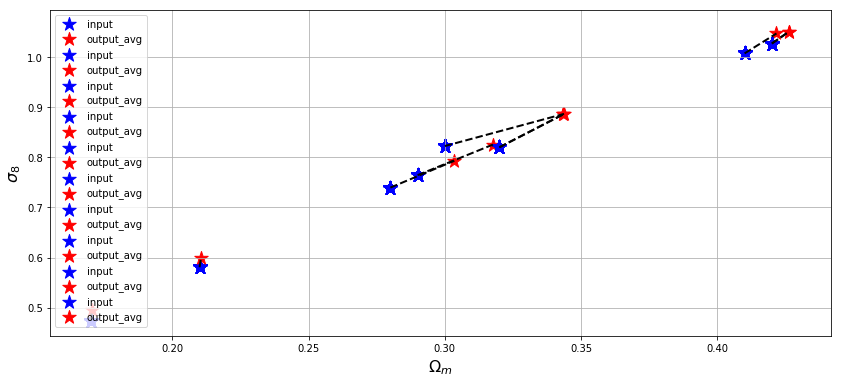

save model to : ./src/model1.1.1_pan//10.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  10 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 60s 783ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 2/10
77/77 [==============================] - 56s 731ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 3/10
77/77 [==============================] - 59s 766ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/10
77/77 [==============================] - 59s 765ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/10
77/77 [==============================] - 60s 777ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss

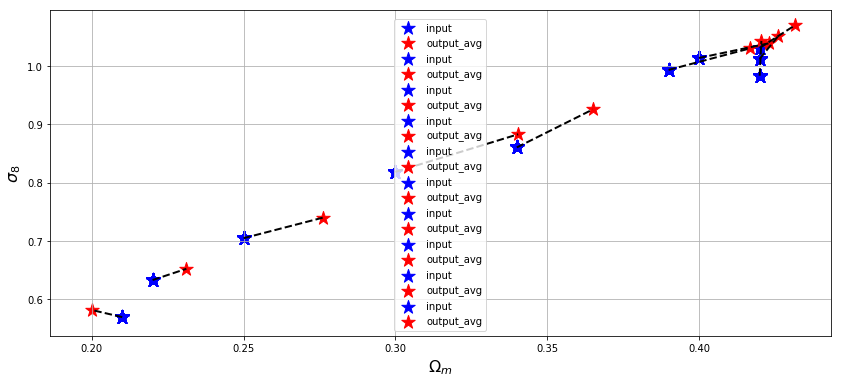

save model to : ./src/model1.1.1_pan//20.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  20 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 61s 790ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 2/10
77/77 [==============================] - 58s 754ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 3/10
77/77 [==============================] - 58s 751ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/10
77/77 [==============================] - 63s 814ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/10
77/77 [==============================] - 61s 791ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss

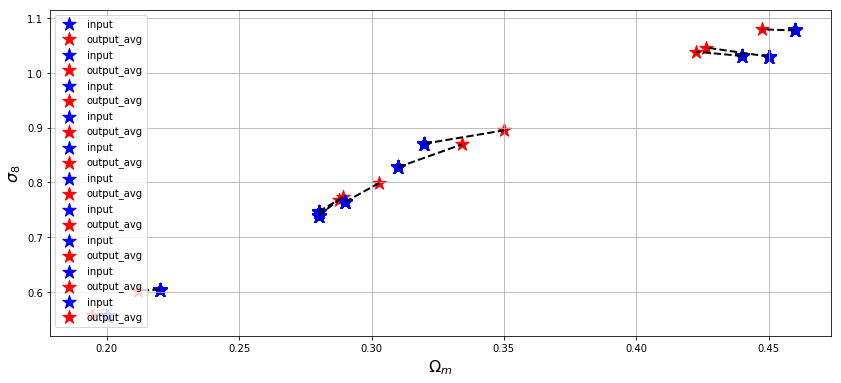

save model to : ./src/model1.1.1_pan//30.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  30 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 57s 745ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 3.6644e-04 - val_mean_squared_error: 3.6644e-04
Epoch 2/10
77/77 [==============================] - 61s 793ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 3.3947e-04 - val_mean_squared_error: 3.3947e-04
Epoch 3/10
77/77 [==============================] - 57s 736ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 3.2530e-04 - val_mean_squared_error: 3.2530e-04
Epoch 4/10
77/77 [==============================] - 56s 727ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 3.1777e-04 - val_mean_squared_error: 3.1777e-04
Epoch 5/10
77/77 [==============================] - 56s 726ms/step - loss: 0.0031 - mean_

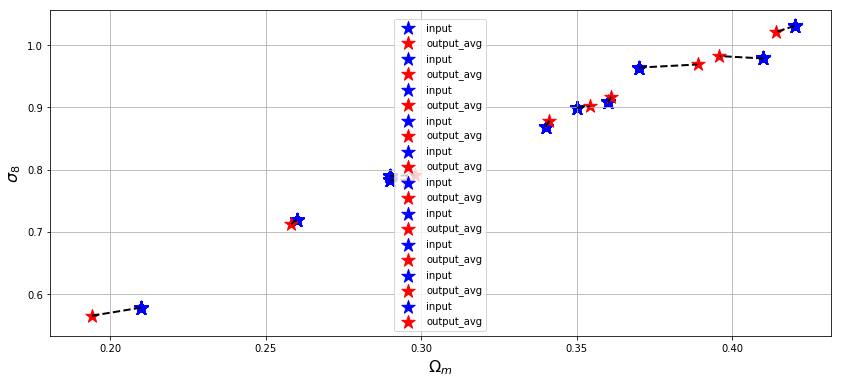

save model to : ./src/model1.1.1_pan//40.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  40 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 63s 812ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 6.3780e-04 - val_mean_squared_error: 6.3780e-04
Epoch 2/10
77/77 [==============================] - 61s 794ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 5.8643e-04 - val_mean_squared_error: 5.8643e-04
Epoch 3/10
77/77 [==============================] - 59s 766ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 5.9774e-04 - val_mean_squared_error: 5.9774e-04
Epoch 4/10
77/77 [==============================] - 59s 765ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 6.0625e-04 - val_mean_squared_error: 6.0625e-04
Epoch 5/10
77/77 [==============================] - 58s 748ms/step - loss: 0.0021 - mean_

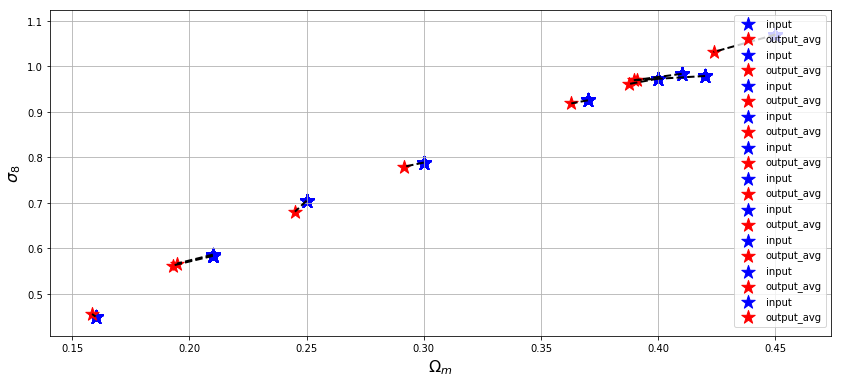

save model to : ./src/model1.1.1_pan//50.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  50 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 60s 781ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 2/10
77/77 [==============================] - 58s 752ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/10
77/77 [==============================] - 59s 760ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/10
77/77 [==============================] - 57s 741ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/10
77/77 [==============================] - 57s 734ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss

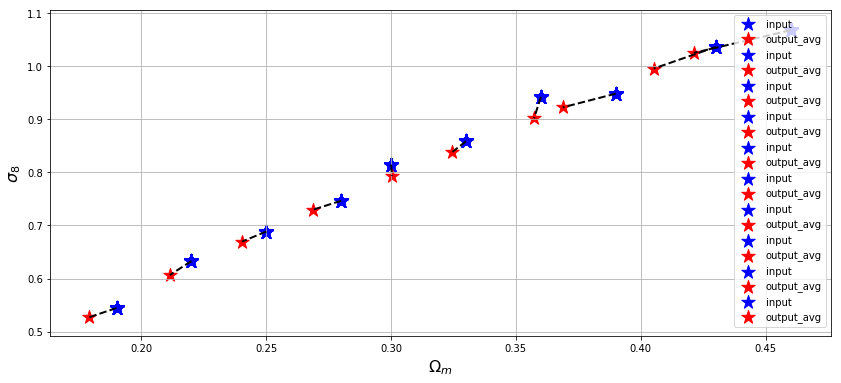

save model to : ./src/model1.1.1_pan//60.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  60 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 60s 774ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 8.7902e-04 - val_mean_squared_error: 8.7902e-04
Epoch 2/10
77/77 [==============================] - 59s 765ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 9.1030e-04 - val_mean_squared_error: 9.1030e-04
Epoch 3/10
77/77 [==============================] - 58s 754ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 9.0512e-04 - val_mean_squared_error: 9.0512e-04
Epoch 4/10
77/77 [==============================] - 58s 749ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 8.2100e-04 - val_mean_squared_error: 8.2100e-04
Epoch 5/10
77/77 [==============================] - 56s 729ms/step - loss: 0.0013 - mean_

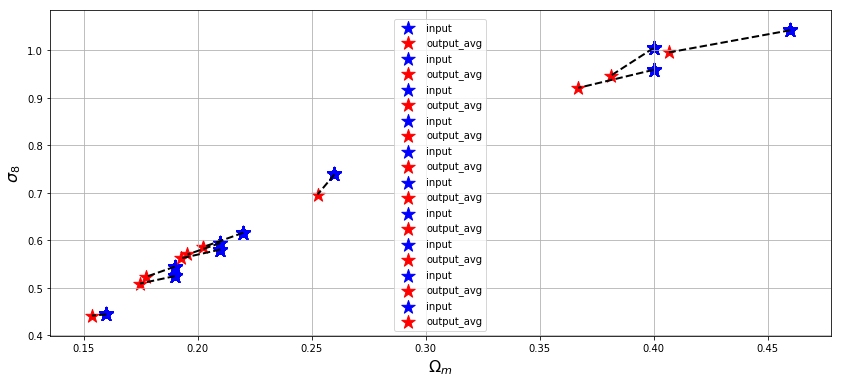

save model to : ./src/model1.1.1_pan//70.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  70 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 57s 745ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 5.7798e-04 - val_mean_squared_error: 5.7798e-04
Epoch 2/10
77/77 [==============================] - 57s 738ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.2859e-04 - val_mean_squared_error: 6.2859e-04
Epoch 3/10
77/77 [==============================] - 62s 806ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.7583e-04 - val_mean_squared_error: 5.7583e-04
Epoch 4/10
77/77 [==============================] - 61s 794ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 5.7255e-04 - val_mean_squared_error: 5.7255e-04
Epoch 5/10
77/77 [==============================] - 60s 775ms/step - loss: 0.0011 - mean_

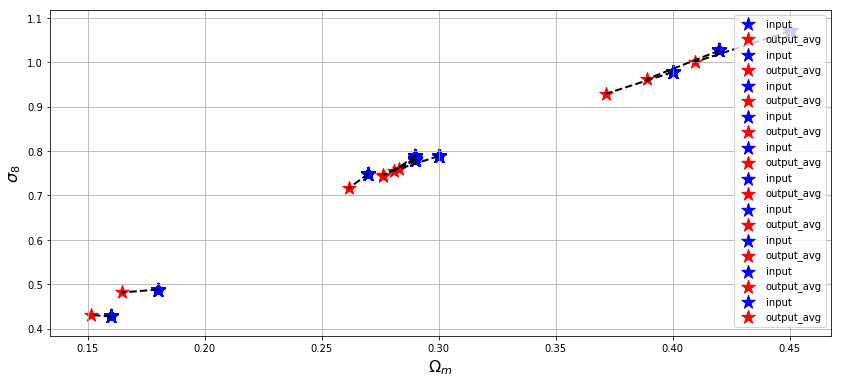

save model to : ./src/model1.1.1_pan//80.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  80 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 62s 805ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2/10
77/77 [==============================] - 63s 815ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 3/10
77/77 [==============================] - 61s 798ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/10
77/77 [==============================] - 62s 808ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 5/10
77/77 [==============================] - 57s 739ms/step - loss: 9.9352e-04 - mean_squared_error: 9.9352e-04 - 

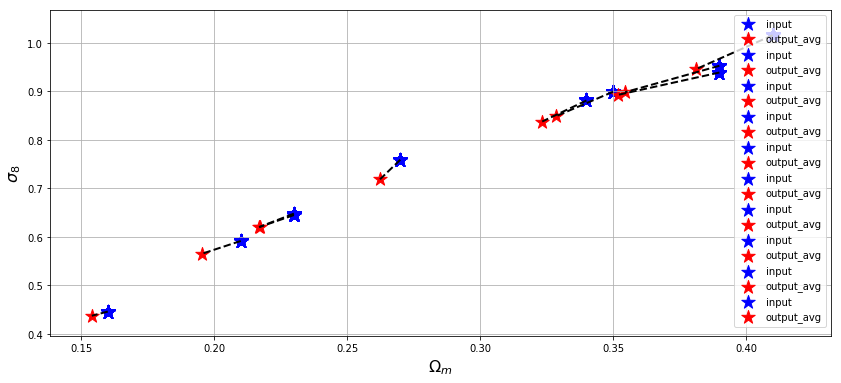

save model to : ./src/model1.1.1_pan//90.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  90 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 58s 749ms/step - loss: 9.7851e-04 - mean_squared_error: 9.7851e-04 - val_loss: 3.7269e-04 - val_mean_squared_error: 3.7269e-04
Epoch 2/10
77/77 [==============================] - 60s 784ms/step - loss: 9.4237e-04 - mean_squared_error: 9.4237e-04 - val_loss: 5.1573e-04 - val_mean_squared_error: 5.1573e-04
Epoch 3/10
77/77 [==============================] - 62s 799ms/step - loss: 9.3263e-04 - mean_squared_error: 9.3263e-04 - val_loss: 6.1149e-04 - val_mean_squared_error: 6.1149e-04
Epoch 4/10
77/77 [==============================] - 57s 734ms/step - loss: 9.4043e-04 - mean_squared_error: 9.4043e-04 - val_loss: 6.1515e-04 - val_mean_squared_error: 6.1515e-04
Epoch 5/10
77/77 [==============================] - 55s 7

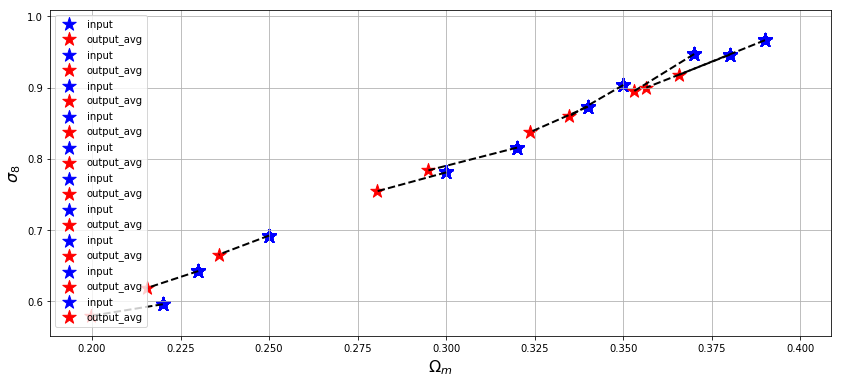

save model to : ./src/model1.1.1_pan//100.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  100 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 60s 782ms/step - loss: 9.0053e-04 - mean_squared_error: 9.0053e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 2/10
77/77 [==============================] - 59s 765ms/step - loss: 8.4260e-04 - mean_squared_error: 8.4260e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 3/10
77/77 [==============================] - 59s 771ms/step - loss: 9.0377e-04 - mean_squared_error: 9.0377e-04 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 4/10
77/77 [==============================] - 53s 693ms/step - loss: 8.7694e-04 - mean_squared_error: 8.7694e-04 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 5/10
77/77 [==============================] - 53s 692ms/step - loss: 8.4088e-04 -

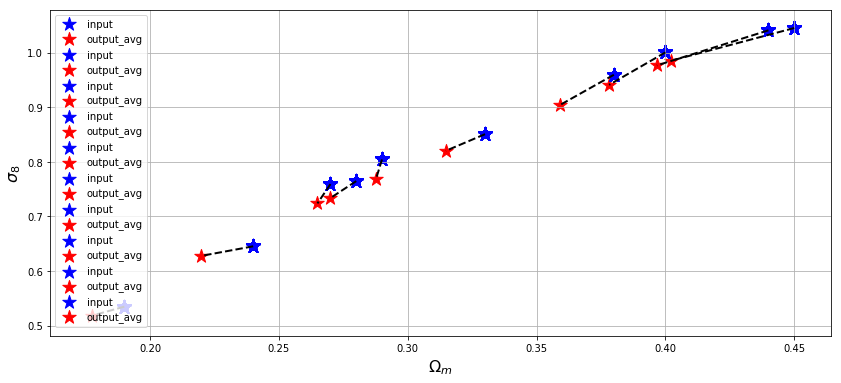

save model to : ./src/model1.1.1_pan//110.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  110 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 54s 707ms/step - loss: 8.4566e-04 - mean_squared_error: 8.4566e-04 - val_loss: 3.5670e-04 - val_mean_squared_error: 3.5670e-04
Epoch 2/10
77/77 [==============================] - 54s 697ms/step - loss: 8.3024e-04 - mean_squared_error: 8.3024e-04 - val_loss: 3.7538e-04 - val_mean_squared_error: 3.7538e-04
Epoch 3/10
77/77 [==============================] - 58s 748ms/step - loss: 8.2781e-04 - mean_squared_error: 8.2781e-04 - val_loss: 3.6850e-04 - val_mean_squared_error: 3.6850e-04
Epoch 4/10
77/77 [==============================] - 57s 743ms/step - loss: 8.2363e-04 - mean_squared_error: 8.2363e-04 - val_loss: 4.0948e-04 - val_mean_squared_error: 4.0948e-04
Epoch 5/10
77/77 [==============================] - 55s

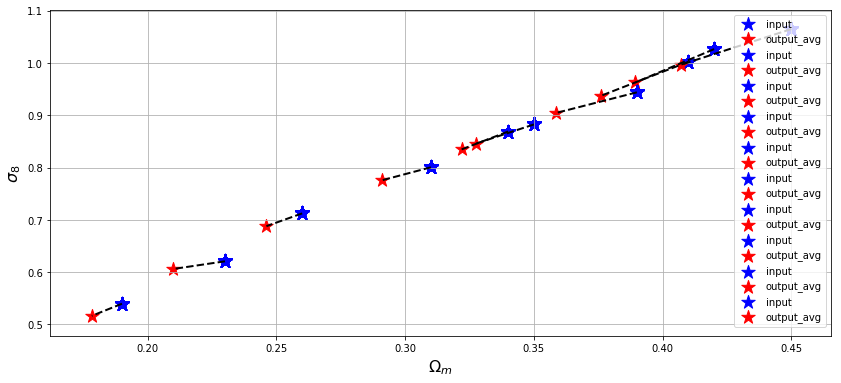

save model to : ./src/model1.1.1_pan//120.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  120 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 60s 773ms/step - loss: 7.9386e-04 - mean_squared_error: 7.9386e-04 - val_loss: 5.6742e-04 - val_mean_squared_error: 5.6742e-04
Epoch 2/10
77/77 [==============================] - 60s 774ms/step - loss: 7.7485e-04 - mean_squared_error: 7.7485e-04 - val_loss: 5.4852e-04 - val_mean_squared_error: 5.4852e-04
Epoch 3/10
77/77 [==============================] - 58s 748ms/step - loss: 7.7452e-04 - mean_squared_error: 7.7452e-04 - val_loss: 5.4374e-04 - val_mean_squared_error: 5.4374e-04
Epoch 4/10
77/77 [==============================] - 56s 724ms/step - loss: 7.6582e-04 - mean_squared_error: 7.6582e-04 - val_loss: 5.6566e-04 - val_mean_squared_error: 5.6566e-04
Epoch 5/10
77/77 [==============================] - 54s

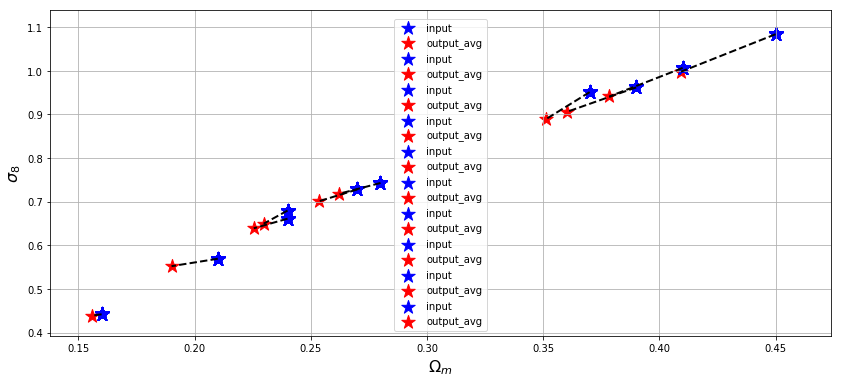

save model to : ./src/model1.1.1_pan//130.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  130 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 62s 800ms/step - loss: 7.5443e-04 - mean_squared_error: 7.5443e-04 - val_loss: 6.5731e-04 - val_mean_squared_error: 6.5731e-04
Epoch 2/10
77/77 [==============================] - 60s 779ms/step - loss: 7.5740e-04 - mean_squared_error: 7.5740e-04 - val_loss: 5.8415e-04 - val_mean_squared_error: 5.8415e-04
Epoch 3/10
77/77 [==============================] - 60s 783ms/step - loss: 7.5967e-04 - mean_squared_error: 7.5967e-04 - val_loss: 5.2236e-04 - val_mean_squared_error: 5.2236e-04
Epoch 4/10
77/77 [==============================] - 63s 815ms/step - loss: 7.6571e-04 - mean_squared_error: 7.6571e-04 - val_loss: 4.9418e-04 - val_mean_squared_error: 4.9418e-04
Epoch 5/10
77/77 [==============================] - 59s

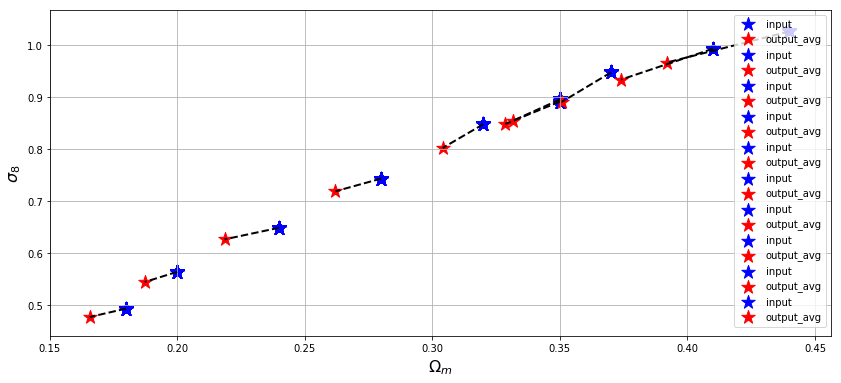

save model to : ./src/model1.1.1_pan//140.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  140 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 60s 780ms/step - loss: 7.3035e-04 - mean_squared_error: 7.3035e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/10
77/77 [==============================] - 58s 757ms/step - loss: 6.9683e-04 - mean_squared_error: 6.9683e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 3/10
77/77 [==============================] - 58s 754ms/step - loss: 7.1688e-04 - mean_squared_error: 7.1688e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/10
77/77 [==============================] - 55s 710ms/step - loss: 7.0817e-04 - mean_squared_error: 7.0817e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/10
77/77 [==============================] - 54s 703ms/step - loss: 7.1611e-04 -

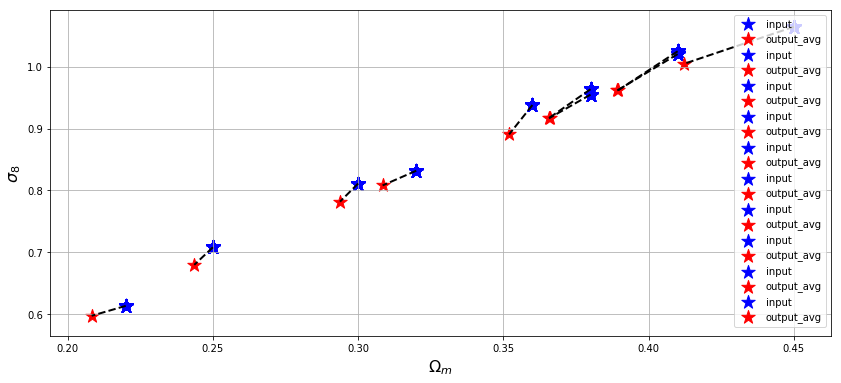

save model to : ./src/model1.1.1_pan//150.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  150 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 58s 757ms/step - loss: 6.8925e-04 - mean_squared_error: 6.8925e-04 - val_loss: 8.2665e-04 - val_mean_squared_error: 8.2665e-04
Epoch 2/10
77/77 [==============================] - 62s 806ms/step - loss: 6.9328e-04 - mean_squared_error: 6.9328e-04 - val_loss: 7.7586e-04 - val_mean_squared_error: 7.7586e-04
Epoch 3/10
77/77 [==============================] - 56s 728ms/step - loss: 6.9219e-04 - mean_squared_error: 6.9219e-04 - val_loss: 8.1462e-04 - val_mean_squared_error: 8.1462e-04
Epoch 4/10
77/77 [==============================] - 57s 739ms/step - loss: 6.9715e-04 - mean_squared_error: 6.9715e-04 - val_loss: 9.5348e-04 - val_mean_squared_error: 9.5348e-04
Epoch 5/10
77/77 [==============================] - 62s

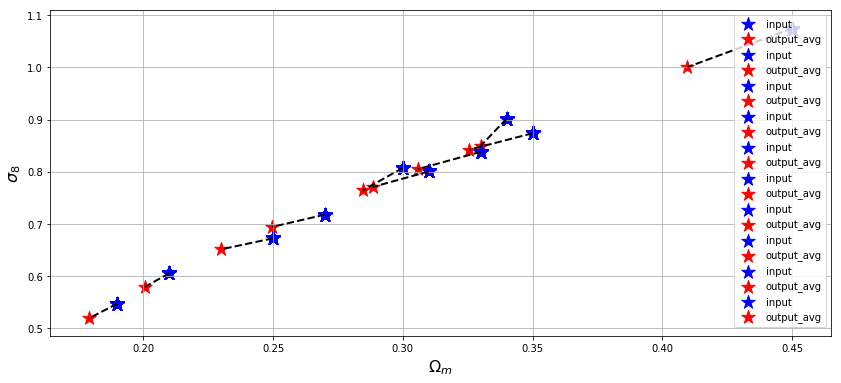

save model to : ./src/model1.1.1_pan//160.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  160 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 54s 696ms/step - loss: 6.9186e-04 - mean_squared_error: 6.9186e-04 - val_loss: 9.6877e-04 - val_mean_squared_error: 9.6877e-04
Epoch 2/10
77/77 [==============================] - 53s 689ms/step - loss: 6.8753e-04 - mean_squared_error: 6.8753e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/10
77/77 [==============================] - 53s 691ms/step - loss: 6.9017e-04 - mean_squared_error: 6.9017e-04 - val_loss: 9.5221e-04 - val_mean_squared_error: 9.5221e-04
Epoch 4/10
77/77 [==============================] - 53s 686ms/step - loss: 6.7636e-04 - mean_squared_error: 6.7636e-04 - val_loss: 8.4634e-04 - val_mean_squared_error: 8.4634e-04
Epoch 5/10
77/77 [==============================] - 53s 687ms/s

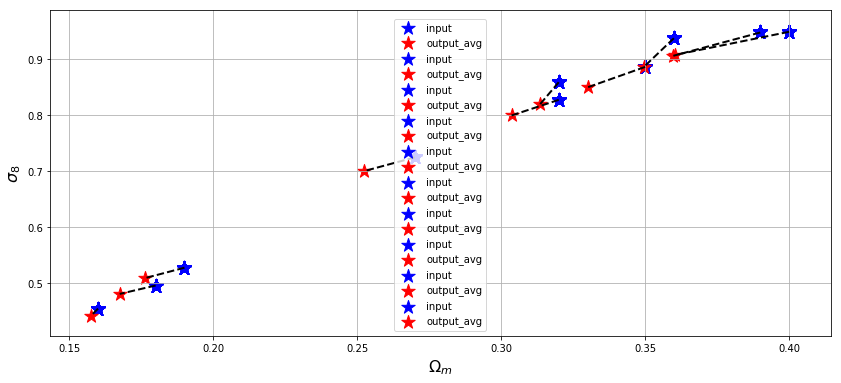

save model to : ./src/model1.1.1_pan//170.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  170 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 52s 681ms/step - loss: 6.5193e-04 - mean_squared_error: 6.5193e-04 - val_loss: 7.6435e-04 - val_mean_squared_error: 7.6435e-04
Epoch 2/10
77/77 [==============================] - 56s 723ms/step - loss: 6.7499e-04 - mean_squared_error: 6.7499e-04 - val_loss: 8.8120e-04 - val_mean_squared_error: 8.8120e-04
Epoch 3/10
77/77 [==============================] - 55s 712ms/step - loss: 6.6295e-04 - mean_squared_error: 6.6295e-04 - val_loss: 8.1643e-04 - val_mean_squared_error: 8.1643e-04
Epoch 4/10
77/77 [==============================] - 54s 701ms/step - loss: 6.5089e-04 - mean_squared_error: 6.5089e-04 - val_loss: 7.7052e-04 - val_mean_squared_error: 7.7052e-04
Epoch 5/10
77/77 [==============================] - 57s

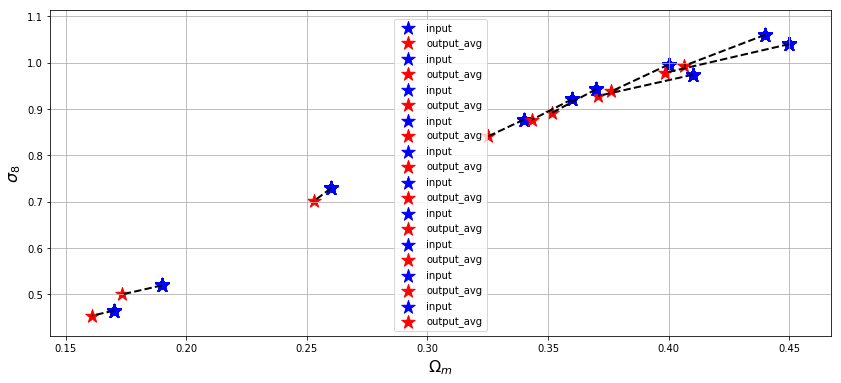

save model to : ./src/model1.1.1_pan//180.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  180 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 58s 759ms/step - loss: 6.4844e-04 - mean_squared_error: 6.4844e-04 - val_loss: 5.7867e-04 - val_mean_squared_error: 5.7867e-04
Epoch 2/10
77/77 [==============================] - 52s 681ms/step - loss: 6.3710e-04 - mean_squared_error: 6.3710e-04 - val_loss: 6.4974e-04 - val_mean_squared_error: 6.4974e-04
Epoch 3/10
77/77 [==============================] - 52s 681ms/step - loss: 6.1528e-04 - mean_squared_error: 6.1528e-04 - val_loss: 7.7480e-04 - val_mean_squared_error: 7.7480e-04
Epoch 4/10
77/77 [==============================] - 51s 664ms/step - loss: 6.4231e-04 - mean_squared_error: 6.4231e-04 - val_loss: 5.9148e-04 - val_mean_squared_error: 5.9148e-04
Epoch 5/10
77/77 [==============================] - 52s

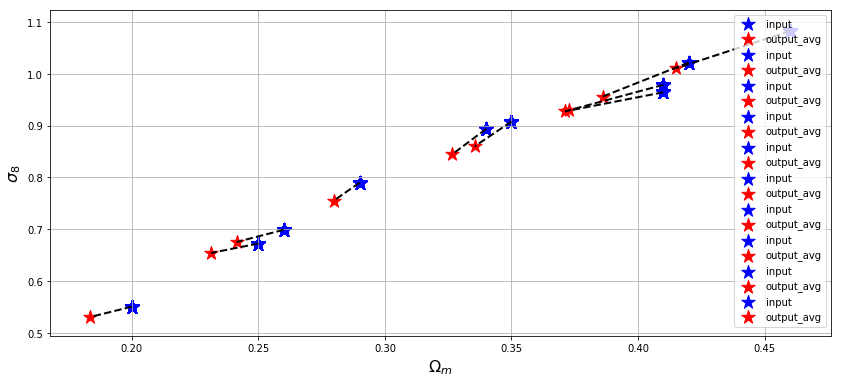

save model to : ./src/model1.1.1_pan//190.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  190 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 57s 741ms/step - loss: 6.0807e-04 - mean_squared_error: 6.0807e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/10
77/77 [==============================] - 54s 703ms/step - loss: 6.4647e-04 - mean_squared_error: 6.4647e-04 - val_loss: 6.5727e-04 - val_mean_squared_error: 6.5727e-04
Epoch 3/10
77/77 [==============================] - 54s 699ms/step - loss: 6.5467e-04 - mean_squared_error: 6.5467e-04 - val_loss: 7.6226e-04 - val_mean_squared_error: 7.6226e-04
Epoch 4/10
77/77 [==============================] - 53s 690ms/step - loss: 6.2105e-04 - mean_squared_error: 6.2105e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 5/10
77/77 [==============================] - 55s 710ms/step - lo

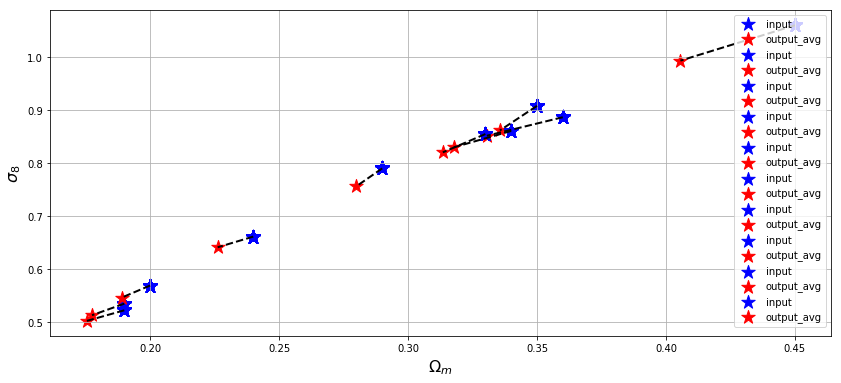

save model to : ./src/model1.1.1_pan//200.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  200 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 53s 688ms/step - loss: 6.0848e-04 - mean_squared_error: 6.0848e-04 - val_loss: 7.6141e-04 - val_mean_squared_error: 7.6141e-04
Epoch 2/10
77/77 [==============================] - 53s 683ms/step - loss: 6.1803e-04 - mean_squared_error: 6.1803e-04 - val_loss: 9.0075e-04 - val_mean_squared_error: 9.0075e-04
Epoch 3/10
77/77 [==============================] - 57s 740ms/step - loss: 6.1631e-04 - mean_squared_error: 6.1631e-04 - val_loss: 7.2682e-04 - val_mean_squared_error: 7.2682e-04
Epoch 4/10
77/77 [==============================] - 56s 722ms/step - loss: 6.0476e-04 - mean_squared_error: 6.0476e-04 - val_loss: 9.0203e-04 - val_mean_squared_error: 9.0203e-04
Epoch 5/10
77/77 [==============================] - 50s

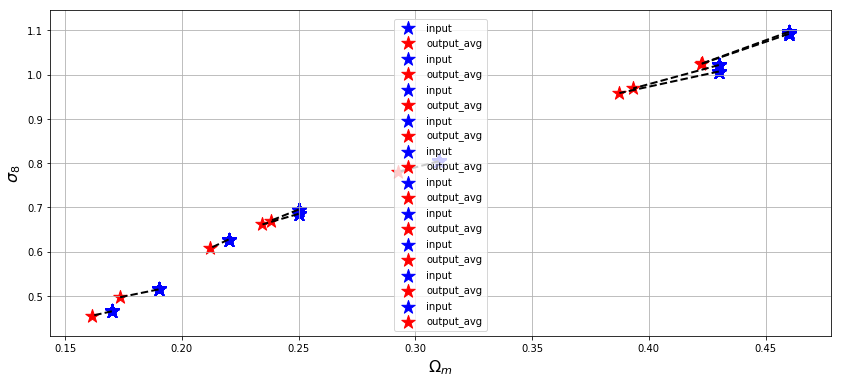

save model to : ./src/model1.1.1_pan//210.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  210 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 51s 669ms/step - loss: 6.1043e-04 - mean_squared_error: 6.1043e-04 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 2/10
77/77 [==============================] - 51s 667ms/step - loss: 6.0405e-04 - mean_squared_error: 6.0405e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 3/10
77/77 [==============================] - 51s 666ms/step - loss: 5.9395e-04 - mean_squared_error: 5.9395e-04 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/10
77/77 [==============================] - 52s 670ms/step - loss: 6.0046e-04 - mean_squared_error: 6.0046e-04 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 5/10
77/77 [==============================] - 52s 680ms/step - loss: 5.9965e-04 -

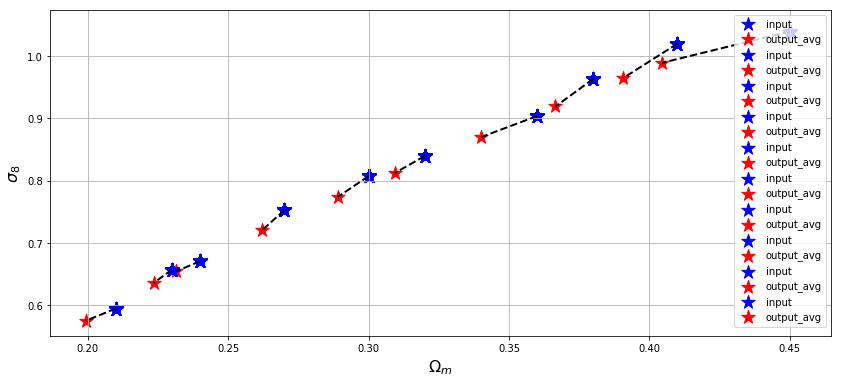

save model to : ./src/model1.1.1_pan//220.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  220 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 56s 731ms/step - loss: 5.9278e-04 - mean_squared_error: 5.9278e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 2/10
77/77 [==============================] - 58s 756ms/step - loss: 5.9224e-04 - mean_squared_error: 5.9224e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 3/10
77/77 [==============================] - 55s 718ms/step - loss: 5.8866e-04 - mean_squared_error: 5.8866e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/10
77/77 [==============================] - 58s 748ms/step - loss: 5.8690e-04 - mean_squared_error: 5.8690e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/10
77/77 [==============================] - 54s 699ms/step - loss: 5.9568e-04 -

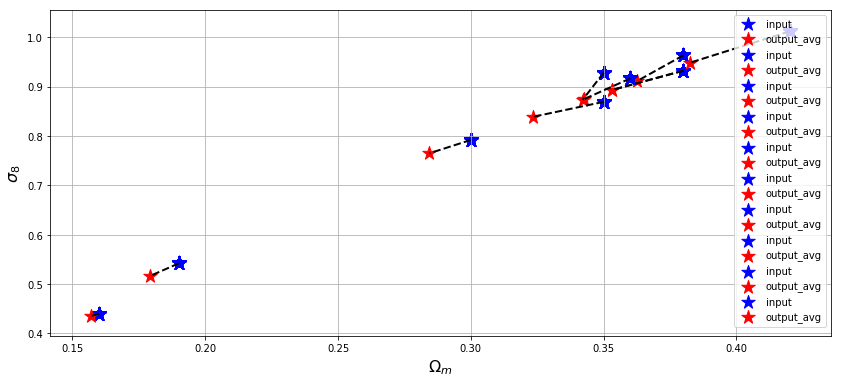

save model to : ./src/model1.1.1_pan//230.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  230 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 55s 708ms/step - loss: 5.8347e-04 - mean_squared_error: 5.8347e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 2/10
77/77 [==============================] - 54s 704ms/step - loss: 5.6996e-04 - mean_squared_error: 5.6996e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/10
77/77 [==============================] - 55s 714ms/step - loss: 5.6189e-04 - mean_squared_error: 5.6189e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 4/10
77/77 [==============================] - 51s 666ms/step - loss: 5.9584e-04 - mean_squared_error: 5.9584e-04 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 5/10
77/77 [==============================] - 53s 691ms/step - loss: 5.7136e-04 -

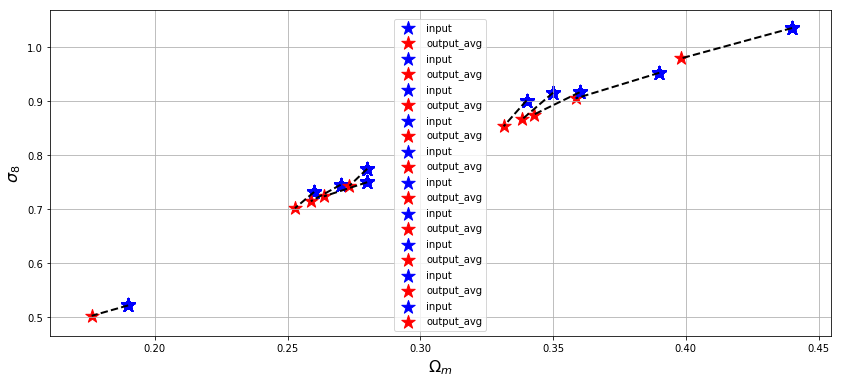

save model to : ./src/model1.1.1_pan//240.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  240 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 55s 709ms/step - loss: 6.0196e-04 - mean_squared_error: 6.0196e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/10
77/77 [==============================] - 53s 684ms/step - loss: 5.8921e-04 - mean_squared_error: 5.8921e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 3/10
77/77 [==============================] - 52s 675ms/step - loss: 5.6931e-04 - mean_squared_error: 5.6931e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 4/10
77/77 [==============================] - 50s 651ms/step - loss: 5.6506e-04 - mean_squared_error: 5.6506e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/10
77/77 [==============================] - 50s 649ms/step - loss: 5.6858e-04 -

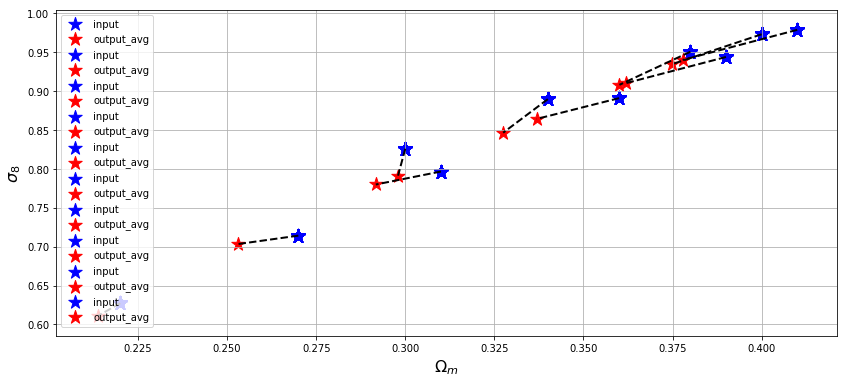

save model to : ./src/model1.1.1_pan//250.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  250 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 54s 701ms/step - loss: 5.5494e-04 - mean_squared_error: 5.5494e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 2/10
77/77 [==============================] - 52s 675ms/step - loss: 5.4550e-04 - mean_squared_error: 5.4550e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/10
77/77 [==============================] - 50s 645ms/step - loss: 5.5683e-04 - mean_squared_error: 5.5683e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/10
77/77 [==============================] - 49s 640ms/step - loss: 5.6558e-04 - mean_squared_error: 5.6558e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/10
77/77 [==============================] - 53s 684ms/step - loss: 5.6005e-04 -

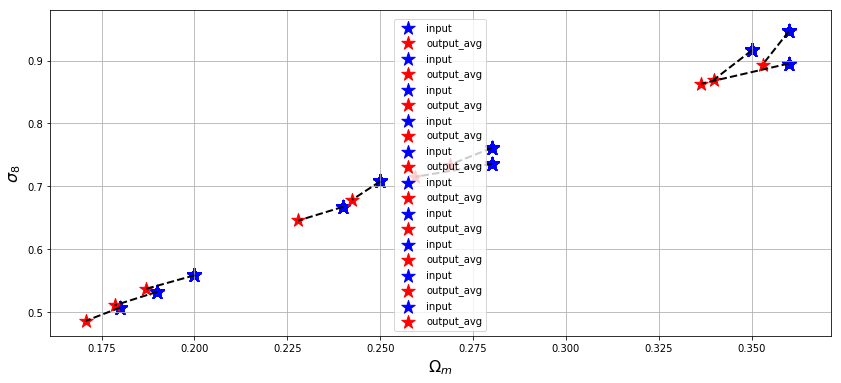

save model to : ./src/model1.1.1_pan//260.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  260 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 54s 706ms/step - loss: 5.5140e-04 - mean_squared_error: 5.5140e-04 - val_loss: 5.5302e-04 - val_mean_squared_error: 5.5302e-04
Epoch 2/10
77/77 [==============================] - 49s 639ms/step - loss: 5.5083e-04 - mean_squared_error: 5.5083e-04 - val_loss: 6.0079e-04 - val_mean_squared_error: 6.0079e-04
Epoch 3/10
77/77 [==============================] - 53s 682ms/step - loss: 5.3198e-04 - mean_squared_error: 5.3198e-04 - val_loss: 5.7234e-04 - val_mean_squared_error: 5.7234e-04
Epoch 4/10
77/77 [==============================] - 51s 661ms/step - loss: 5.6696e-04 - mean_squared_error: 5.6696e-04 - val_loss: 7.1075e-04 - val_mean_squared_error: 7.1075e-04
Epoch 5/10
77/77 [==============================] - 53s

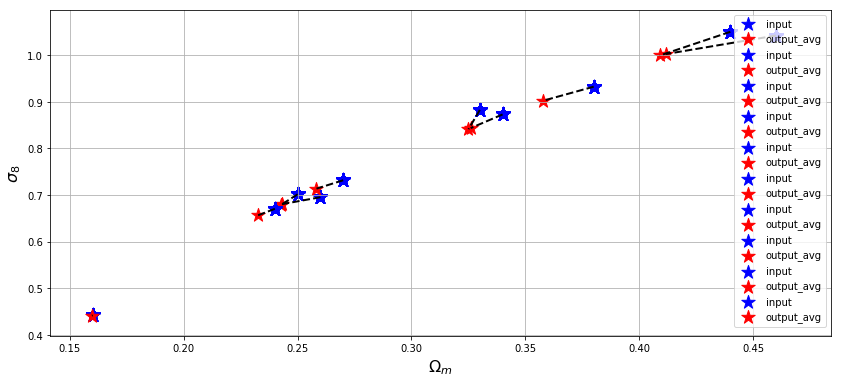

save model to : ./src/model1.1.1_pan//270.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  270 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 52s 680ms/step - loss: 5.4287e-04 - mean_squared_error: 5.4287e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 2/10
77/77 [==============================] - 48s 626ms/step - loss: 5.5217e-04 - mean_squared_error: 5.5217e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 3/10
77/77 [==============================] - 48s 628ms/step - loss: 5.5013e-04 - mean_squared_error: 5.5013e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 4/10
77/77 [==============================] - 48s 622ms/step - loss: 5.4581e-04 - mean_squared_error: 5.4581e-04 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 5/10
77/77 [==============================] - 49s 633ms/step - loss: 5.4118e-04 -

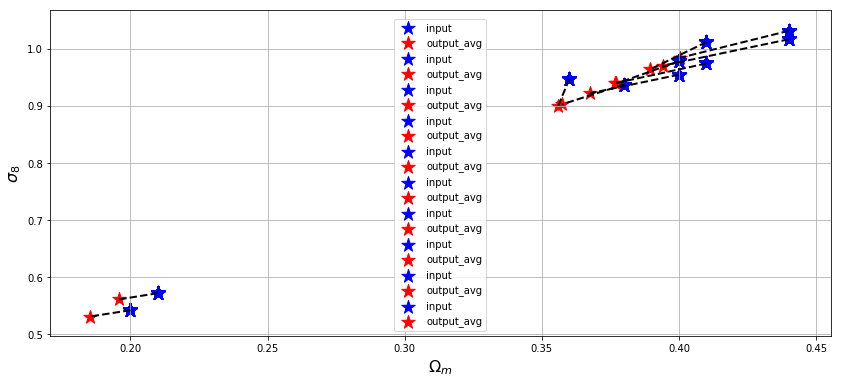

save model to : ./src/model1.1.1_pan//280.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  280 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 54s 698ms/step - loss: 5.5610e-04 - mean_squared_error: 5.5610e-04 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 2/10
77/77 [==============================] - 52s 677ms/step - loss: 5.5568e-04 - mean_squared_error: 5.5568e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 3/10
77/77 [==============================] - 52s 673ms/step - loss: 5.2885e-04 - mean_squared_error: 5.2885e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 4/10
77/77 [==============================] - 55s 708ms/step - loss: 5.3379e-04 - mean_squared_error: 5.3379e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/10
77/77 [==============================] - 54s 707ms/step - loss: 5.2282e-04 -

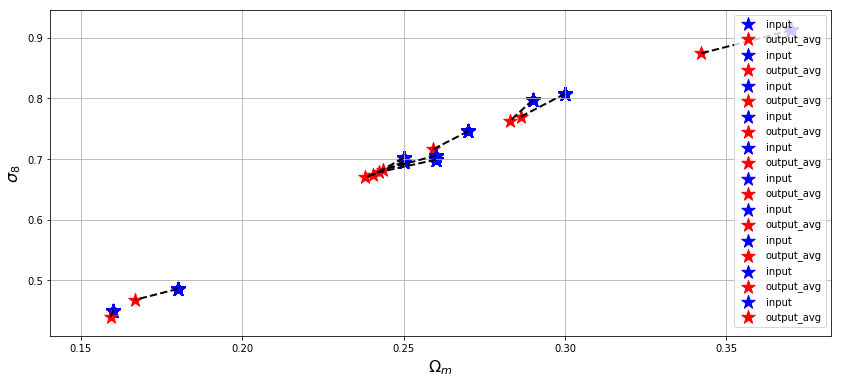

save model to : ./src/model1.1.1_pan//290.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  290 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 53s 687ms/step - loss: 5.1433e-04 - mean_squared_error: 5.1433e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/10
77/77 [==============================] - 52s 681ms/step - loss: 5.4328e-04 - mean_squared_error: 5.4328e-04 - val_loss: 9.6633e-04 - val_mean_squared_error: 9.6633e-04
Epoch 3/10
77/77 [==============================] - 47s 615ms/step - loss: 5.4457e-04 - mean_squared_error: 5.4457e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/10
77/77 [==============================] - 48s 620ms/step - loss: 5.4724e-04 - mean_squared_error: 5.4724e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 5/10
77/77 [==============================] - 49s 642ms/step - loss: 5.14

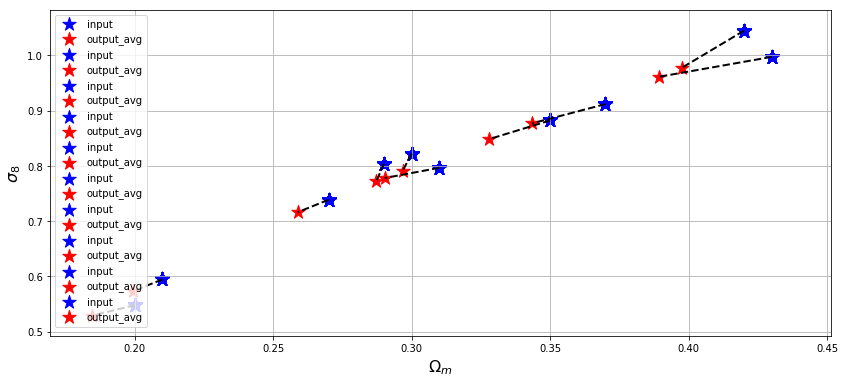

save model to : ./src/model1.1.1_pan//300.save
###############################################
Begin training for src/model1.1.1_pan/, current epochs =  300 ; max_epochs =  300 ...
###############################################
Epoch 1/10
77/77 [==============================] - 58s 758ms/step - loss: 5.5331e-04 - mean_squared_error: 5.5331e-04 - val_loss: 3.5893e-04 - val_mean_squared_error: 3.5893e-04
Epoch 2/10
77/77 [==============================] - 54s 704ms/step - loss: 5.3423e-04 - mean_squared_error: 5.3423e-04 - val_loss: 3.8941e-04 - val_mean_squared_error: 3.8941e-04
Epoch 3/10
77/77 [==============================] - 53s 690ms/step - loss: 5.4506e-04 - mean_squared_error: 5.4506e-04 - val_loss: 4.4088e-04 - val_mean_squared_error: 4.4088e-04
Epoch 4/10
77/77 [==============================] - 54s 695ms/step - loss: 5.1793e-04 - mean_squared_error: 5.1793e-04 - val_loss: 4.2571e-04 - val_mean_squared_error: 4.2571e-04
Epoch 5/10
77/77 [==============================] - 58s

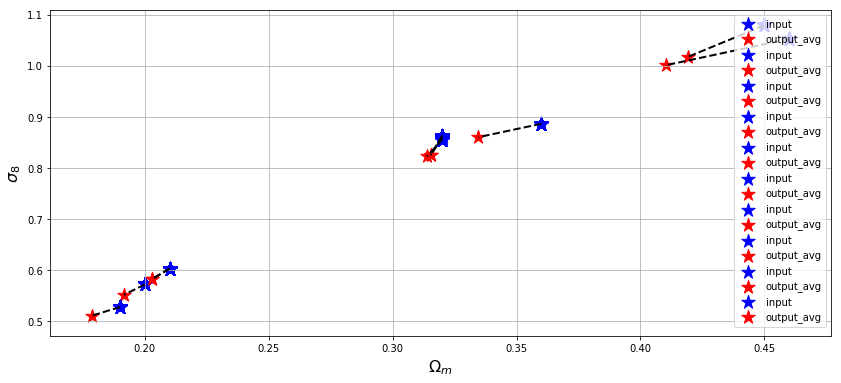

save model to : ./src/model1.1.1_pan//310.save


In [12]:
epochs = 0 

step_epoch = 10

while epochs <= max_epochs:

    print('###############################################')
    print('Begin training for '+modelname+', current epochs = ', epochs, '; max_epochs = ', max_epochs, '...')
    print('###############################################')
    outputf.write('###############################################\n')
    outputf.write('Begin training for '+modelname+', current epochs = '+ str(epochs)+ '; max_epochs = '+str( max_epochs)+ '...\n')
    outputf.write('###############################################\n')

    if True:
        nowmodel.fit_generator(train_generator(),
                    steps_per_epoch=465//batch_size,  # 数据规格可能大小不对应
                    epochs=step_epoch,
                    verbose=1,
                    validation_data=(x_test,y_test))
    epochs += step_epoch

    filepath = './'+modelname+'/'+str(epochs)+'.save'
    # Plot validation
    if True:
        fig, ax = None, None
        for row in range(10):
            x_test, y_test = create_validate_sample(1, use_random=True, startid=row)
            fig, ax = plot_test(nowmodel, x_test, y_test, fig=fig, ax=ax)
        ax.grid(); plt.show()
        ax.set_title('#-epochs = '+str(epochs), fontsize=16)
        fig.savefig(filepath+'.png', format='png')
    print('save model to :', filepath )
    outputf.write('save model to :'+str(filepath)+ '\n')
    keras.models.save_model(nowmodel, filepath)

outputf.close()
